https://www.youtube.com/watch?v=Oi_jE5sp-A0&list=PLh6SAYydrIpctChfPFBlopqw-TGjwWf_8&index=3

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
%matplotlib inline
def imshow(Is,titles,savePath=None):
    plt.figure(facecolor='w',figsize=(16,16))
    n=len(Is)
    sq=int(np.ceil(n**0.5))
    r,c=int(np.ceil(n/sq)),sq
    for i in range(n):
        plt.subplot(n,c,i+1)
        plt.imshow(Is[i],norm=colors.NoNorm(),cmap='gray')
        plt.axis('off')
        plt.title(titles[i])
        if savePath:
            cv2.imwrite(os.path.join(savePath,titles[i]+'.png'),Is[i])
#             plt.imsave(os.path.join(savePath,titles[i]),Is[i],cmap='gray')
    plt.tight_layout()
def drawHistogram(I,label='orign'):
    h,c=histogramAnalysis(I,Normed=False)
    plt.figure()
    xx=np.arange(256)
    plt.bar(xx,h[0])
    plt.figure()
    plt.plot(xx,c[0],label=label)
    plt.plot(xx[[0,-1]],c[0][[0,-1]],label='equalization rule' )
    plt.legend()
    plt.tight_layout()

In [43]:
MyImage=cv2.imread('./precessing/low_contrast_1.jpg',cv2.IMREAD_GRAYSCALE)

In [44]:
def contrast(I,factor):
    I=I*factor
    I=np.minimum(I,255)
    I=I.astype(np.uint8)
    return I

In [45]:
def brightness(I,amount):
    I=I+amount
    return np.minimum(np.maximum(I,0),255)

In [46]:
def invert(I):return 255-I

In [47]:
def threshold(I,t):return (I<=t)*0+(I>t)*255

In [48]:
def autoContract(I,min=None,max=None):
    I=I.copy()
    if I.ndim==2:I=np.expand_dims(I,2)
    if min is None:
        min=np.min(I,axis=(0,1),keepdims=True)+1e-4
    if max is None:
        max=np.max(I,axis=(0,1),keepdims=True)
    #(x-min)/(max-min)=(xnew-0)/(255-0)
    I=255.0*(I-min)/(max-min)
    I= np.minimum(np.maximum(I,0),255)
    I=np.squeeze(I)
    return I.astype(np.uint8)

In [49]:
def modify_autoContract(I,p=0.002):
    I=I.copy()
    size=I.shape[0]*I.shape[1]

    if I.ndim==2:I=np.expand_dims(I,axis=2)
    C=I.shape[2]
    min,max=[],[]
    for c in range(C):
        h,_=np.histogram(I[:,:,c],bins=256,range=(0,255))
        cum_h=np.cumsum(h)
        a_low=int(p*size)
        a_high=size-a_low
        _minDensity=np.argwhere(cum_h>=a_low).ravel()[0]
        _maxDensity=np.argwhere(cum_h<a_high).ravel()[-1]
        min.append(_minDensity)
        max.append(_maxDensity)
    min=np.array(min)
    max=np.array(max)
    min.shape=(1,1,C)
    max.shape=(1,1,C)
    return autoContract(I,min,max)

In [50]:
def histogramAnalysis(I,Normed=False):
    '''
        compute the histogram and cumulative histogram of each channel 
        of image I
        return:hist,cum_hist,list,0-C-1
    '''
    oldshape=I.shape
    if I.ndim==2:I=np.expand_dims(I,axis=2)
    
    C=I.shape[2]
    hist,cum_hist=[],[]
    for i in range(C):
        _h,_=np.histogram(I,bins=256,range=(0,255))
        _h=_h.astype(np.float32)
        _c=np.cumsum(_h)*1.0
        if Normed:
            _h/=_c[-1]
            _c/=_c[-1]
        hist.append(_h)
        cum_hist.append(_c)
        
    I.shape=oldshape
    
    return hist,cum_hist
def matchHistogram(I,refMap):
    '''
    refMap shold be like this
        f(color,cdf_color)--->newcolor
        cdf_color mean the percent of pixel that have dencity<=color
    '''
    I=I.copy()
        
    if I.ndim==2:I=np.expand_dims(I,axis=2)
    Inew=I.copy()
    
    C=I.shape[2]
    h,c=histogramAnalysis(I,True)
    

    for ch in range(C):
        Ic=I[:,:,ch]
        InewC=Inew[:,:,ch]
        cdf=c[ch]
        for d in range(0,256):
            mask=(d==Ic)
#             d_update=np.floor(255*cdf[d]/size)
            d_update=refMap(d,cdf)
            
            InewC[mask]=np.round(d_update)
    Inew=np.minimum(np.maximum(Inew,0),255).astype(np.uint8)
    return np.squeeze(Inew)

# https://www.youtube.com/watch?v=z_Gm3UL_j_0&list=PLh6SAYydrIpctChfPFBlopqw-TGjwWf_8&index=7
def equalization(I):
    f=lambda p,cdf:255*cdf[p]
    I=matchHistogram(I,f)
    return I

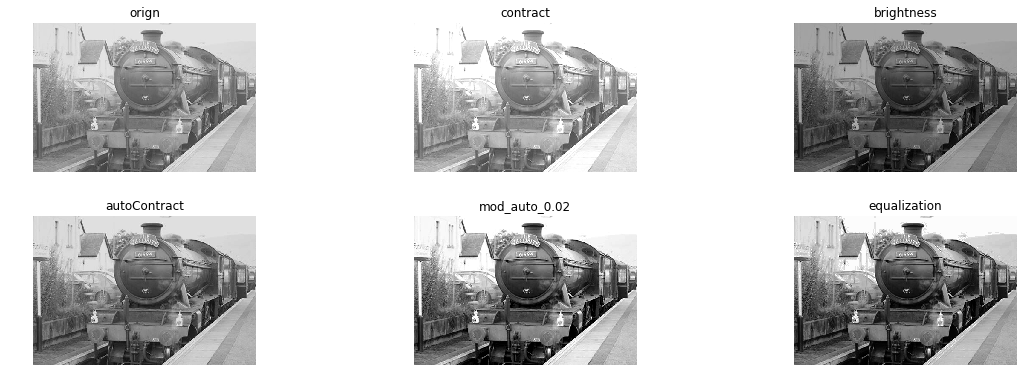

In [51]:
images=[MyImage,contrast(MyImage,1.2),
        brightness(MyImage,-60),autoContract(MyImage),
        modify_autoContract(MyImage,0.02),equalization(MyImage)]
titles=['orign','contract','brightness','autoContract','mod_auto_0.02','equalization']
imshow(images,titles,'precessing')

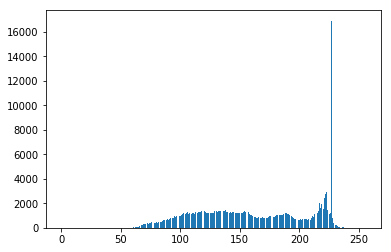

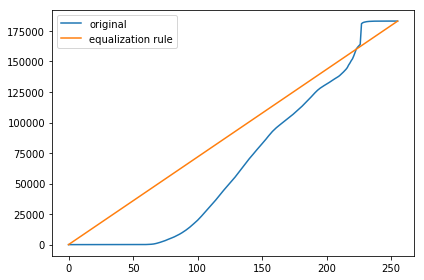

In [52]:
drawHistogram(MyImage,'original')

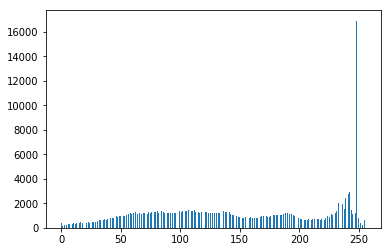

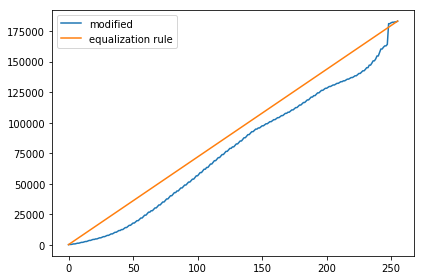

In [53]:
drawHistogram(modify_autoContract(MyImage),'modified')

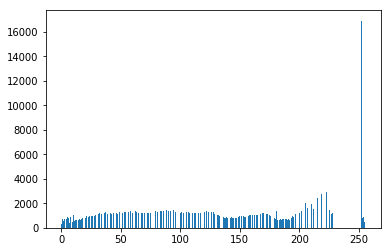

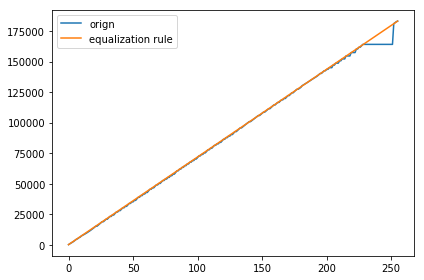

In [54]:
drawHistogram(equalization(MyImage))